In [1]:
import numpy as np
from util import *

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.linear_model

from scipy.stats import spearmanr as cor

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Merge
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
from keras.models import load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM

Using TensorFlow backend.


# Data

In [2]:
header, data, dates = load_csv("../data/treasure.csv")

In [3]:
#Generating ticks for the figure.
count = 0
mem = ""
locations = []
ticks = []
for i in dates:
    if i[-2:] != mem:
        mem = i[-2:]
        locations.append(count)
        ticks.append(i)
    count += 1

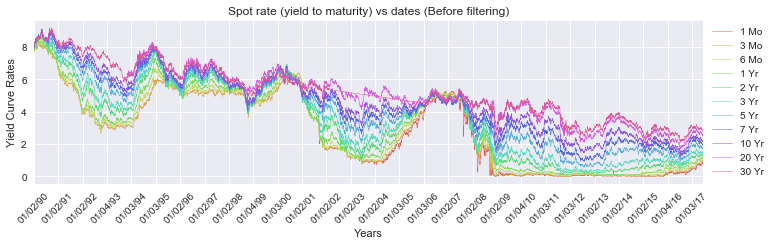

In [4]:
plt.figure(figsize=(12,3))
colors = sns.color_palette("hls", data.shape[1])
for i in range(data.shape[1]):
    temp = [(j,data[:, i][j]) for j in range(len(data[:, i])) if data[:, i][j] > 0]
    #print header[i], "data is missing:", data.shape[0]-len(temp), "out of", data.shape[0]
    
    plt.plot([j[0] for j in temp], [j[1] for j in temp], label=header[i], linewidth=0.5, color=colors[i])
plt.ylabel("Yield Curve Rates")
plt.xlabel("Years")
plt.title("Spot rate (yield to maturity) vs dates (Before filtering)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, data.shape[0])
plt.xticks(locations, ticks, rotation=45)
plt.show()

In [5]:
data = data[:, [1,2,3,4,5,6,7,8]]
header = header[[1,2,3,4,5,6,7,8]]
data = remove0rows(data)

Removed 20


In [6]:
# Taking the first order difference
data2 = differ(np.sqrt(data), 1)

In [7]:
# Rescaling the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data2 = scaler.fit_transform(data2)

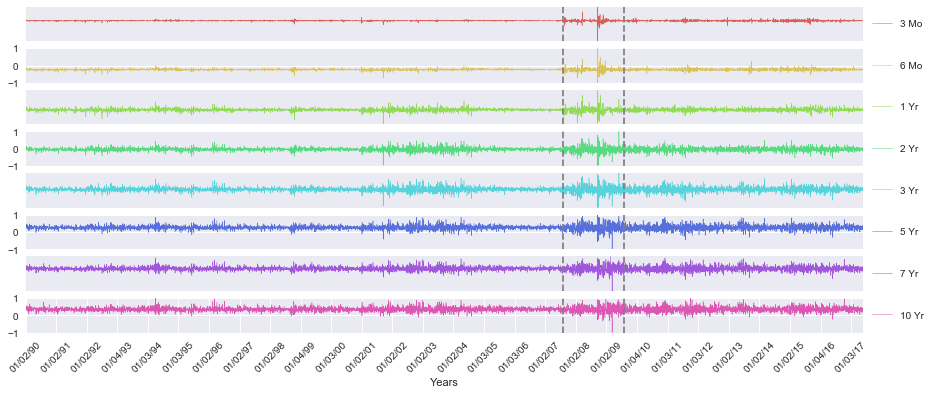

In [8]:
plt.figure(figsize=(15,6))
colors = sns.color_palette("hls", data.shape[1])
for i in range(data2.shape[1]):
    plt.subplot(8,1,i+1)
    plt.plot(data2[:, i], label=header[i], linewidth=0.5, color=colors[i])
    plt.xlim(0, data2.shape[0])
    plt.ylim(-1, 1)
    if i%2 == 0: 
        plt.yticks([],[])
    plt.xticks([], [])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axvline(4400, color="gray", ls="--")
    plt.axvline(4900, color="gray", ls="--")
plt.xlabel("Years")
plt.xticks(locations, ticks, rotation=45)
plt.show()

In [9]:
timeseries1 = generate_data(data2, futures=[1, 7, 30], interval=10)

In [10]:
pca = PCA(3)
pcaed_data = pca.fit_transform(data2)
timeseries2 = generate_data(pcaed_data, futures=[1, 7, 30], interval=10)

# What do we test?

We want to make the ranking of the following models on different time horizon for predicting 3mo maturity yield curve.

Models:
1. RW --> PCAed
3. AR(p) --> PCAed data
4. VAR(p) --> PCAed and Raw
5. 4-layer DNN --> PCAed and Raw
6. 4-layer LSTM --> PCAed and Raw

Horizon:
- 1 day
- 7 days
- 30 days

Metric:
- MSE

In [11]:
results = {}

In [12]:
futures = [1,7,30]

In [13]:
target = 0

# RW

In [14]:
results["RW"] = {}

In [15]:
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        prediction += pca.inverse_transform(timeseries2[f][fold]["test"][0][:, -1, :])[:, target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    results["RW"][f] = (MSE(prediction, truth), prediction, truth)

# AR(p)

In [16]:
results["AR(p)"] = {}

In [17]:
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        predicted_pcs = []
        for pc in range(3):
            # individually regress past pcs against the current one.
            y = timeseries2[f][fold]["train"][1][:, pc]
            x = timeseries2[f][fold]["train"][0][:, :, pc]
            lr = sklearn.linear_model.LinearRegression()
            lr.fit(x, y)
            temp = lr.predict(timeseries2[f][fold]["test"][0][:, :, pc])
            predicted_pcs.append(temp.tolist())
        temp = np.transpose(np.array(predicted_pcs))
        prediction += pca.inverse_transform(temp)[:, target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["AR(p)"][f] = (MSE(prediction, truth), prediction, truth)

# VAR(p)-PCA

In [18]:
results["VAR(p)-PCA"] = {}

In [19]:
a = 0.000001
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1][:, target]
        x = timeseries2[f][fold]["train"][0]
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]))
        
        en = sklearn.linear_model.ElasticNet(alpha = a, max_iter=2000)
        en.fit(x, y)
        #print "Sparcity: ", len([i for i in en.coef_ if i != 0]), "out of", len(en.coef_)
        x2 = timeseries2[f][fold]["test"][0]
        x2 = x2.reshape((x2.shape[0], x2.shape[1]*x2.shape[2]))
        prediction += en.predict(x2).tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["VAR(p)-PCA"][f] = (MSE(prediction, truth), prediction, truth)

# VAR(p)-RAW

In [20]:
results["VAR(p)-RAW"] = {}

In [21]:
a = 0.000001
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1][:, target]
        x = timeseries1[f][fold]["train"][0]
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]))
        
        en = sklearn.linear_model.ElasticNet(alpha = a, max_iter=2000)
        en.fit(x, y)
        #print "Sparcity: ", len([i for i in en.coef_ if i != 0]), "out of", len(en.coef_)
        x2 = timeseries1[f][fold]["test"][0]
        x2 = x2.reshape((x2.shape[0], x2.shape[1]*x2.shape[2]))
        prediction += en.predict(x2).tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["VAR(p)-RAW"][f] = (MSE(prediction, truth), prediction, truth)

# DNN model (4 layers)-RAW

In [22]:
def makeDNN(size):
    model = Sequential()
    model.add(Dense(20, input_shape=(size,)))
    model.add(Activation("tanh"))
    model.add(Dense(10)) 
    model.add(Activation("tanh"))
    model.add(Dense(8))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [23]:
results["DNN"] = {}

In [26]:
a = 0.0001
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1]
        x = timeseries1[f][fold]["train"][0]
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]))
        
        model = makeDNN(x.shape[1])
        filepath="model2/bestDNN_"+str(f)+"_"+str(fold)+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        model.fit(x, y,
          epochs=300, 
          batch_size=256,
          callbacks=callbacks_list,
          validation_split=0.1,
          verbose=0
          )
        
        model = load_model("model2/bestDNN_"+str(f)+"_"+str(fold)+".hdf5")
        x2 = timeseries1[f][fold]["test"][0]
        x2 = x2.reshape((x2.shape[0], x2.shape[1]*x2.shape[2]))
        prediction += model.predict(x2)[:,target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["DNN"][f] = (MSE(prediction, truth), prediction, truth)

Epoch 00000: val_loss improved from inf to 0.04584, saving model to model2/bestDNN_1_0.hdf5
Epoch 00001: val_loss improved from 0.04584 to 0.02874, saving model to model2/bestDNN_1_0.hdf5
Epoch 00002: val_loss improved from 0.02874 to 0.02225, saving model to model2/bestDNN_1_0.hdf5
Epoch 00003: val_loss improved from 0.02225 to 0.01979, saving model to model2/bestDNN_1_0.hdf5
Epoch 00004: val_loss improved from 0.01979 to 0.01842, saving model to model2/bestDNN_1_0.hdf5
Epoch 00005: val_loss improved from 0.01842 to 0.01741, saving model to model2/bestDNN_1_0.hdf5
Epoch 00006: val_loss improved from 0.01741 to 0.01674, saving model to model2/bestDNN_1_0.hdf5
Epoch 00007: val_loss improved from 0.01674 to 0.01621, saving model to model2/bestDNN_1_0.hdf5
Epoch 00008: val_loss improved from 0.01621 to 0.01578, saving model to model2/bestDNN_1_0.hdf5
Epoch 00009: val_loss improved from 0.01578 to 0.01540, saving model to model2/bestDNN_1_0.hdf5
Epoch 00010: val_loss improved from 0.01540 

Epoch 00121: val_loss did not improve
Epoch 00122: val_loss did not improve
Epoch 00123: val_loss did not improve
Epoch 00124: val_loss did not improve
Epoch 00125: val_loss did not improve
Epoch 00126: val_loss did not improve
Epoch 00127: val_loss did not improve
Epoch 00128: val_loss did not improve
Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss did not improve
Epoch 00132: val_loss did not improve
Epoch 00133: val_loss did not improve
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss did not improve
Epoch 00136: val_loss improved from 0.01234 to 0.01234, saving model to model2/bestDNN_1_0.hdf5
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss improved from 0.01234 to 0.01233, saving model to model2/bestDNN_1_0.hdf5
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss did not improve
Epoch 00141: val_loss did not improve
Epoch 00142: val_loss did not improve
Epoch 00143: val_loss did not improve
Epoch 0014

Epoch 00009: val_loss improved from 0.01467 to 0.01450, saving model to model2/bestDNN_1_1.hdf5
Epoch 00010: val_loss improved from 0.01450 to 0.01427, saving model to model2/bestDNN_1_1.hdf5
Epoch 00011: val_loss improved from 0.01427 to 0.01408, saving model to model2/bestDNN_1_1.hdf5
Epoch 00012: val_loss improved from 0.01408 to 0.01393, saving model to model2/bestDNN_1_1.hdf5
Epoch 00013: val_loss improved from 0.01393 to 0.01379, saving model to model2/bestDNN_1_1.hdf5
Epoch 00014: val_loss improved from 0.01379 to 0.01369, saving model to model2/bestDNN_1_1.hdf5
Epoch 00015: val_loss improved from 0.01369 to 0.01357, saving model to model2/bestDNN_1_1.hdf5
Epoch 00016: val_loss improved from 0.01357 to 0.01351, saving model to model2/bestDNN_1_1.hdf5
Epoch 00017: val_loss improved from 0.01351 to 0.01344, saving model to model2/bestDNN_1_1.hdf5
Epoch 00018: val_loss improved from 0.01344 to 0.01336, saving model to model2/bestDNN_1_1.hdf5
Epoch 00019: val_loss improved from 0.01

Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss did not improve
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did not improve
Epoch 00173: val_loss did not improve
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss improved from 0.01225 to 0.01223, saving model to model2/bestDNN_1_1.hdf5
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not 

Epoch 00031: val_loss improved from 0.01272 to 0.01272, saving model to model2/bestDNN_1_2.hdf5
Epoch 00032: val_loss did not improve
Epoch 00033: val_loss improved from 0.01272 to 0.01267, saving model to model2/bestDNN_1_2.hdf5
Epoch 00034: val_loss improved from 0.01267 to 0.01264, saving model to model2/bestDNN_1_2.hdf5
Epoch 00035: val_loss did not improve
Epoch 00036: val_loss did not improve
Epoch 00037: val_loss did not improve
Epoch 00038: val_loss did not improve
Epoch 00039: val_loss improved from 0.01264 to 0.01259, saving model to model2/bestDNN_1_2.hdf5
Epoch 00040: val_loss did not improve
Epoch 00041: val_loss did not improve
Epoch 00042: val_loss improved from 0.01259 to 0.01258, saving model to model2/bestDNN_1_2.hdf5
Epoch 00043: val_loss did not improve
Epoch 00044: val_loss improved from 0.01258 to 0.01254, saving model to model2/bestDNN_1_2.hdf5
Epoch 00045: val_loss did not improve
Epoch 00046: val_loss improved from 0.01254 to 0.01253, saving model to model2/bes

Epoch 00224: val_loss did not improve
Epoch 00225: val_loss did not improve
Epoch 00226: val_loss did not improve
Epoch 00227: val_loss did not improve
Epoch 00228: val_loss did not improve
Epoch 00229: val_loss did not improve
Epoch 00230: val_loss did not improve
Epoch 00231: val_loss did not improve
Epoch 00232: val_loss did not improve
Epoch 00233: val_loss did not improve
Epoch 00234: val_loss did not improve
Epoch 00235: val_loss did not improve
Epoch 00236: val_loss did not improve
Epoch 00237: val_loss did not improve
Epoch 00238: val_loss did not improve
Epoch 00239: val_loss did not improve
Epoch 00240: val_loss did not improve
Epoch 00241: val_loss did not improve
Epoch 00242: val_loss did not improve
Epoch 00243: val_loss did not improve
Epoch 00244: val_loss did not improve
Epoch 00245: val_loss did not improve
Epoch 00246: val_loss did not improve
Epoch 00247: val_loss did not improve
Epoch 00248: val_loss did not improve
Epoch 00249: val_loss did not improve
Epoch 00250:

Epoch 00068: val_loss improved from 0.01243 to 0.01241, saving model to model2/bestDNN_1_3.hdf5
Epoch 00069: val_loss did not improve
Epoch 00070: val_loss did not improve
Epoch 00071: val_loss did not improve
Epoch 00072: val_loss improved from 0.01241 to 0.01239, saving model to model2/bestDNN_1_3.hdf5
Epoch 00073: val_loss improved from 0.01239 to 0.01239, saving model to model2/bestDNN_1_3.hdf5
Epoch 00074: val_loss did not improve
Epoch 00075: val_loss did not improve
Epoch 00076: val_loss did not improve
Epoch 00077: val_loss improved from 0.01239 to 0.01238, saving model to model2/bestDNN_1_3.hdf5
Epoch 00078: val_loss improved from 0.01238 to 0.01236, saving model to model2/bestDNN_1_3.hdf5
Epoch 00079: val_loss improved from 0.01236 to 0.01235, saving model to model2/bestDNN_1_3.hdf5
Epoch 00080: val_loss did not improve
Epoch 00081: val_loss did not improve
Epoch 00082: val_loss did not improve
Epoch 00083: val_loss did not improve
Epoch 00084: val_loss improved from 0.01235 

Epoch 00229: val_loss did not improve
Epoch 00230: val_loss did not improve
Epoch 00231: val_loss did not improve
Epoch 00232: val_loss improved from 0.01211 to 0.01210, saving model to model2/bestDNN_1_3.hdf5
Epoch 00233: val_loss did not improve
Epoch 00234: val_loss did not improve
Epoch 00235: val_loss did not improve
Epoch 00236: val_loss did not improve
Epoch 00237: val_loss improved from 0.01210 to 0.01210, saving model to model2/bestDNN_1_3.hdf5
Epoch 00238: val_loss did not improve
Epoch 00239: val_loss did not improve
Epoch 00240: val_loss did not improve
Epoch 00241: val_loss did not improve
Epoch 00242: val_loss did not improve
Epoch 00243: val_loss did not improve
Epoch 00244: val_loss did not improve
Epoch 00245: val_loss did not improve
Epoch 00246: val_loss did not improve
Epoch 00247: val_loss did not improve
Epoch 00248: val_loss did not improve
Epoch 00249: val_loss did not improve
Epoch 00250: val_loss did not improve
Epoch 00251: val_loss improved from 0.01210 to 0

Epoch 00062: val_loss improved from 0.01899 to 0.01895, saving model to model2/bestDNN_1_4.hdf5
Epoch 00063: val_loss did not improve
Epoch 00064: val_loss did not improve
Epoch 00065: val_loss did not improve
Epoch 00066: val_loss did not improve
Epoch 00067: val_loss improved from 0.01895 to 0.01895, saving model to model2/bestDNN_1_4.hdf5
Epoch 00068: val_loss improved from 0.01895 to 0.01894, saving model to model2/bestDNN_1_4.hdf5
Epoch 00069: val_loss improved from 0.01894 to 0.01891, saving model to model2/bestDNN_1_4.hdf5
Epoch 00070: val_loss did not improve
Epoch 00071: val_loss improved from 0.01891 to 0.01889, saving model to model2/bestDNN_1_4.hdf5
Epoch 00072: val_loss did not improve
Epoch 00073: val_loss did not improve
Epoch 00074: val_loss did not improve
Epoch 00075: val_loss improved from 0.01889 to 0.01889, saving model to model2/bestDNN_1_4.hdf5
Epoch 00076: val_loss did not improve
Epoch 00077: val_loss improved from 0.01889 to 0.01887, saving model to model2/bes

Epoch 00259: val_loss did not improve
Epoch 00260: val_loss did not improve
Epoch 00261: val_loss did not improve
Epoch 00262: val_loss did not improve
Epoch 00263: val_loss did not improve
Epoch 00264: val_loss did not improve
Epoch 00265: val_loss did not improve
Epoch 00266: val_loss did not improve
Epoch 00267: val_loss did not improve
Epoch 00268: val_loss did not improve
Epoch 00269: val_loss did not improve
Epoch 00270: val_loss did not improve
Epoch 00271: val_loss did not improve
Epoch 00272: val_loss did not improve
Epoch 00273: val_loss did not improve
Epoch 00274: val_loss did not improve
Epoch 00275: val_loss did not improve
Epoch 00276: val_loss did not improve
Epoch 00277: val_loss did not improve
Epoch 00278: val_loss did not improve
Epoch 00279: val_loss did not improve
Epoch 00280: val_loss did not improve
Epoch 00281: val_loss did not improve
Epoch 00282: val_loss did not improve
Epoch 00283: val_loss did not improve
Epoch 00284: val_loss did not improve
Epoch 00285:

Epoch 00114: val_loss did not improve
Epoch 00115: val_loss did not improve
Epoch 00116: val_loss did not improve
Epoch 00117: val_loss did not improve
Epoch 00118: val_loss did not improve
Epoch 00119: val_loss did not improve
Epoch 00120: val_loss did not improve
Epoch 00121: val_loss did not improve
Epoch 00122: val_loss did not improve
Epoch 00123: val_loss did not improve
Epoch 00124: val_loss did not improve
Epoch 00125: val_loss improved from 0.01238 to 0.01237, saving model to model2/bestDNN_7_0.hdf5
Epoch 00126: val_loss did not improve
Epoch 00127: val_loss did not improve
Epoch 00128: val_loss did not improve
Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss did not improve
Epoch 00132: val_loss did not improve
Epoch 00133: val_loss did not improve
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss improved from 0.01237 to 0.01235, saving model to model2/bestDNN_7_0.hdf5
Epoch 00136: val_loss did not improve
Epoch 0013

Epoch 00011: val_loss improved from 0.01329 to 0.01309, saving model to model2/bestDNN_7_1.hdf5
Epoch 00012: val_loss improved from 0.01309 to 0.01305, saving model to model2/bestDNN_7_1.hdf5
Epoch 00013: val_loss improved from 0.01305 to 0.01297, saving model to model2/bestDNN_7_1.hdf5
Epoch 00014: val_loss improved from 0.01297 to 0.01293, saving model to model2/bestDNN_7_1.hdf5
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss improved from 0.01293 to 0.01280, saving model to model2/bestDNN_7_1.hdf5
Epoch 00017: val_loss improved from 0.01280 to 0.01278, saving model to model2/bestDNN_7_1.hdf5
Epoch 00018: val_loss improved from 0.01278 to 0.01276, saving model to model2/bestDNN_7_1.hdf5
Epoch 00019: val_loss improved from 0.01276 to 0.01274, saving model to model2/bestDNN_7_1.hdf5
Epoch 00020: val_loss improved from 0.01274 to 0.01271, saving model to model2/bestDNN_7_1.hdf5
Epoch 00021: val_loss improved from 0.01271 to 0.01265, saving model to model2/bestDNN_7_1.hdf5
Ep

Epoch 00182: val_loss did not improve
Epoch 00183: val_loss did not improve
Epoch 00184: val_loss did not improve
Epoch 00185: val_loss did not improve
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss did not improve
Epoch 00188: val_loss did not improve
Epoch 00189: val_loss did not improve
Epoch 00190: val_loss did not improve
Epoch 00191: val_loss did not improve
Epoch 00192: val_loss did not improve
Epoch 00193: val_loss did not improve
Epoch 00194: val_loss did not improve
Epoch 00195: val_loss did not improve
Epoch 00196: val_loss did not improve
Epoch 00197: val_loss did not improve
Epoch 00198: val_loss did not improve
Epoch 00199: val_loss did not improve
Epoch 00200: val_loss did not improve
Epoch 00201: val_loss did not improve
Epoch 00202: val_loss did not improve
Epoch 00203: val_loss did not improve
Epoch 00204: val_loss did not improve
Epoch 00205: val_loss did not improve
Epoch 00206: val_loss did not improve
Epoch 00207: val_loss did not improve
Epoch 00208:

Epoch 00052: val_loss did not improve
Epoch 00053: val_loss improved from 0.01238 to 0.01238, saving model to model2/bestDNN_7_2.hdf5
Epoch 00054: val_loss did not improve
Epoch 00055: val_loss did not improve
Epoch 00056: val_loss did not improve
Epoch 00057: val_loss did not improve
Epoch 00058: val_loss improved from 0.01238 to 0.01237, saving model to model2/bestDNN_7_2.hdf5
Epoch 00059: val_loss improved from 0.01237 to 0.01235, saving model to model2/bestDNN_7_2.hdf5
Epoch 00060: val_loss did not improve
Epoch 00061: val_loss did not improve
Epoch 00062: val_loss did not improve
Epoch 00063: val_loss improved from 0.01235 to 0.01234, saving model to model2/bestDNN_7_2.hdf5
Epoch 00064: val_loss did not improve
Epoch 00065: val_loss did not improve
Epoch 00066: val_loss did not improve
Epoch 00067: val_loss did not improve
Epoch 00068: val_loss did not improve
Epoch 00069: val_loss did not improve
Epoch 00070: val_loss did not improve
Epoch 00071: val_loss did not improve
Epoch 00

Epoch 00259: val_loss did not improve
Epoch 00260: val_loss did not improve
Epoch 00261: val_loss did not improve
Epoch 00262: val_loss did not improve
Epoch 00263: val_loss did not improve
Epoch 00264: val_loss did not improve
Epoch 00265: val_loss did not improve
Epoch 00266: val_loss did not improve
Epoch 00267: val_loss did not improve
Epoch 00268: val_loss did not improve
Epoch 00269: val_loss did not improve
Epoch 00270: val_loss did not improve
Epoch 00271: val_loss did not improve
Epoch 00272: val_loss did not improve
Epoch 00273: val_loss did not improve
Epoch 00274: val_loss did not improve
Epoch 00275: val_loss did not improve
Epoch 00276: val_loss did not improve
Epoch 00277: val_loss did not improve
Epoch 00278: val_loss did not improve
Epoch 00279: val_loss did not improve
Epoch 00280: val_loss did not improve
Epoch 00281: val_loss did not improve
Epoch 00282: val_loss did not improve
Epoch 00283: val_loss did not improve
Epoch 00284: val_loss did not improve
Epoch 00285:

Epoch 00088: val_loss did not improve
Epoch 00089: val_loss did not improve
Epoch 00090: val_loss did not improve
Epoch 00091: val_loss did not improve
Epoch 00092: val_loss did not improve
Epoch 00093: val_loss did not improve
Epoch 00094: val_loss did not improve
Epoch 00095: val_loss did not improve
Epoch 00096: val_loss did not improve
Epoch 00097: val_loss improved from 0.01239 to 0.01238, saving model to model2/bestDNN_7_3.hdf5
Epoch 00098: val_loss did not improve
Epoch 00099: val_loss did not improve
Epoch 00100: val_loss did not improve
Epoch 00101: val_loss did not improve
Epoch 00102: val_loss improved from 0.01238 to 0.01237, saving model to model2/bestDNN_7_3.hdf5
Epoch 00103: val_loss did not improve
Epoch 00104: val_loss did not improve
Epoch 00105: val_loss did not improve
Epoch 00106: val_loss did not improve
Epoch 00107: val_loss did not improve
Epoch 00108: val_loss did not improve
Epoch 00109: val_loss did not improve
Epoch 00110: val_loss did not improve
Epoch 0011

Epoch 00000: val_loss improved from inf to 0.05180, saving model to model2/bestDNN_7_4.hdf5
Epoch 00001: val_loss improved from 0.05180 to 0.03158, saving model to model2/bestDNN_7_4.hdf5
Epoch 00002: val_loss improved from 0.03158 to 0.02654, saving model to model2/bestDNN_7_4.hdf5
Epoch 00003: val_loss improved from 0.02654 to 0.02448, saving model to model2/bestDNN_7_4.hdf5
Epoch 00004: val_loss improved from 0.02448 to 0.02326, saving model to model2/bestDNN_7_4.hdf5
Epoch 00005: val_loss improved from 0.02326 to 0.02245, saving model to model2/bestDNN_7_4.hdf5
Epoch 00006: val_loss improved from 0.02245 to 0.02190, saving model to model2/bestDNN_7_4.hdf5
Epoch 00007: val_loss improved from 0.02190 to 0.02154, saving model to model2/bestDNN_7_4.hdf5
Epoch 00008: val_loss improved from 0.02154 to 0.02123, saving model to model2/bestDNN_7_4.hdf5
Epoch 00009: val_loss improved from 0.02123 to 0.02098, saving model to model2/bestDNN_7_4.hdf5
Epoch 00010: val_loss improved from 0.02098 

Epoch 00145: val_loss did not improve
Epoch 00146: val_loss did not improve
Epoch 00147: val_loss did not improve
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153: val_loss did not improve
Epoch 00154: val_loss did not improve
Epoch 00155: val_loss did not improve
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss did not improve
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171:

Epoch 00028: val_loss improved from 0.01263 to 0.01257, saving model to model2/bestDNN_30_0.hdf5
Epoch 00029: val_loss improved from 0.01257 to 0.01254, saving model to model2/bestDNN_30_0.hdf5
Epoch 00030: val_loss did not improve
Epoch 00031: val_loss improved from 0.01254 to 0.01254, saving model to model2/bestDNN_30_0.hdf5
Epoch 00032: val_loss did not improve
Epoch 00033: val_loss improved from 0.01254 to 0.01250, saving model to model2/bestDNN_30_0.hdf5
Epoch 00034: val_loss did not improve
Epoch 00035: val_loss did not improve
Epoch 00036: val_loss improved from 0.01250 to 0.01247, saving model to model2/bestDNN_30_0.hdf5
Epoch 00037: val_loss did not improve
Epoch 00038: val_loss improved from 0.01247 to 0.01246, saving model to model2/bestDNN_30_0.hdf5
Epoch 00039: val_loss improved from 0.01246 to 0.01244, saving model to model2/bestDNN_30_0.hdf5
Epoch 00040: val_loss did not improve
Epoch 00041: val_loss did not improve
Epoch 00042: val_loss did not improve
Epoch 00043: val_

Epoch 00228: val_loss did not improve
Epoch 00229: val_loss did not improve
Epoch 00230: val_loss did not improve
Epoch 00231: val_loss did not improve
Epoch 00232: val_loss did not improve
Epoch 00233: val_loss did not improve
Epoch 00234: val_loss did not improve
Epoch 00235: val_loss did not improve
Epoch 00236: val_loss did not improve
Epoch 00237: val_loss did not improve
Epoch 00238: val_loss did not improve
Epoch 00239: val_loss did not improve
Epoch 00240: val_loss did not improve
Epoch 00241: val_loss did not improve
Epoch 00242: val_loss did not improve
Epoch 00243: val_loss did not improve
Epoch 00244: val_loss did not improve
Epoch 00245: val_loss did not improve
Epoch 00246: val_loss did not improve
Epoch 00247: val_loss did not improve
Epoch 00248: val_loss did not improve
Epoch 00249: val_loss did not improve
Epoch 00250: val_loss did not improve
Epoch 00251: val_loss did not improve
Epoch 00252: val_loss did not improve
Epoch 00253: val_loss did not improve
Epoch 00254:

Epoch 00088: val_loss did not improve
Epoch 00089: val_loss did not improve
Epoch 00090: val_loss did not improve
Epoch 00091: val_loss did not improve
Epoch 00092: val_loss did not improve
Epoch 00093: val_loss did not improve
Epoch 00094: val_loss did not improve
Epoch 00095: val_loss did not improve
Epoch 00096: val_loss did not improve
Epoch 00097: val_loss did not improve
Epoch 00098: val_loss did not improve
Epoch 00099: val_loss did not improve
Epoch 00100: val_loss did not improve
Epoch 00101: val_loss did not improve
Epoch 00102: val_loss did not improve
Epoch 00103: val_loss did not improve
Epoch 00104: val_loss did not improve
Epoch 00105: val_loss did not improve
Epoch 00106: val_loss did not improve
Epoch 00107: val_loss did not improve
Epoch 00108: val_loss did not improve
Epoch 00109: val_loss did not improve
Epoch 00110: val_loss did not improve
Epoch 00111: val_loss did not improve
Epoch 00112: val_loss did not improve
Epoch 00113: val_loss did not improve
Epoch 00114:

Epoch 00004: val_loss improved from 0.01572 to 0.01486, saving model to model2/bestDNN_30_2.hdf5
Epoch 00005: val_loss improved from 0.01486 to 0.01423, saving model to model2/bestDNN_30_2.hdf5
Epoch 00006: val_loss improved from 0.01423 to 0.01387, saving model to model2/bestDNN_30_2.hdf5
Epoch 00007: val_loss improved from 0.01387 to 0.01372, saving model to model2/bestDNN_30_2.hdf5
Epoch 00008: val_loss improved from 0.01372 to 0.01340, saving model to model2/bestDNN_30_2.hdf5
Epoch 00009: val_loss improved from 0.01340 to 0.01320, saving model to model2/bestDNN_30_2.hdf5
Epoch 00010: val_loss improved from 0.01320 to 0.01319, saving model to model2/bestDNN_30_2.hdf5
Epoch 00011: val_loss improved from 0.01319 to 0.01302, saving model to model2/bestDNN_30_2.hdf5
Epoch 00012: val_loss improved from 0.01302 to 0.01293, saving model to model2/bestDNN_30_2.hdf5
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss improved from 0.01293 to 0.01284, saving model to model2/bestDNN_30

Epoch 00185: val_loss did not improve
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss did not improve
Epoch 00188: val_loss did not improve
Epoch 00189: val_loss did not improve
Epoch 00190: val_loss did not improve
Epoch 00191: val_loss did not improve
Epoch 00192: val_loss did not improve
Epoch 00193: val_loss did not improve
Epoch 00194: val_loss did not improve
Epoch 00195: val_loss did not improve
Epoch 00196: val_loss did not improve
Epoch 00197: val_loss did not improve
Epoch 00198: val_loss did not improve
Epoch 00199: val_loss did not improve
Epoch 00200: val_loss did not improve
Epoch 00201: val_loss did not improve
Epoch 00202: val_loss did not improve
Epoch 00203: val_loss did not improve
Epoch 00204: val_loss did not improve
Epoch 00205: val_loss did not improve
Epoch 00206: val_loss did not improve
Epoch 00207: val_loss did not improve
Epoch 00208: val_loss did not improve
Epoch 00209: val_loss did not improve
Epoch 00210: val_loss did not improve
Epoch 00211:

Epoch 00042: val_loss did not improve
Epoch 00043: val_loss did not improve
Epoch 00044: val_loss did not improve
Epoch 00045: val_loss did not improve
Epoch 00046: val_loss improved from 0.01266 to 0.01265, saving model to model2/bestDNN_30_3.hdf5
Epoch 00047: val_loss improved from 0.01265 to 0.01262, saving model to model2/bestDNN_30_3.hdf5
Epoch 00048: val_loss improved from 0.01262 to 0.01260, saving model to model2/bestDNN_30_3.hdf5
Epoch 00049: val_loss did not improve
Epoch 00050: val_loss did not improve
Epoch 00051: val_loss did not improve
Epoch 00052: val_loss did not improve
Epoch 00053: val_loss improved from 0.01260 to 0.01259, saving model to model2/bestDNN_30_3.hdf5
Epoch 00054: val_loss improved from 0.01259 to 0.01258, saving model to model2/bestDNN_30_3.hdf5
Epoch 00055: val_loss did not improve
Epoch 00056: val_loss did not improve
Epoch 00057: val_loss did not improve
Epoch 00058: val_loss did not improve
Epoch 00059: val_loss did not improve
Epoch 00060: val_loss

Epoch 00244: val_loss did not improve
Epoch 00245: val_loss did not improve
Epoch 00246: val_loss did not improve
Epoch 00247: val_loss did not improve
Epoch 00248: val_loss did not improve
Epoch 00249: val_loss did not improve
Epoch 00250: val_loss did not improve
Epoch 00251: val_loss did not improve
Epoch 00252: val_loss did not improve
Epoch 00253: val_loss did not improve
Epoch 00254: val_loss did not improve
Epoch 00255: val_loss did not improve
Epoch 00256: val_loss did not improve
Epoch 00257: val_loss did not improve
Epoch 00258: val_loss did not improve
Epoch 00259: val_loss did not improve
Epoch 00260: val_loss did not improve
Epoch 00261: val_loss did not improve
Epoch 00262: val_loss did not improve
Epoch 00263: val_loss did not improve
Epoch 00264: val_loss did not improve
Epoch 00265: val_loss did not improve
Epoch 00266: val_loss did not improve
Epoch 00267: val_loss did not improve
Epoch 00268: val_loss did not improve
Epoch 00269: val_loss did not improve
Epoch 00270:

Epoch 00075: val_loss did not improve
Epoch 00076: val_loss improved from 0.01850 to 0.01849, saving model to model2/bestDNN_30_4.hdf5
Epoch 00077: val_loss improved from 0.01849 to 0.01848, saving model to model2/bestDNN_30_4.hdf5
Epoch 00078: val_loss improved from 0.01848 to 0.01848, saving model to model2/bestDNN_30_4.hdf5
Epoch 00079: val_loss did not improve
Epoch 00080: val_loss improved from 0.01848 to 0.01848, saving model to model2/bestDNN_30_4.hdf5
Epoch 00081: val_loss did not improve
Epoch 00082: val_loss did not improve
Epoch 00083: val_loss did not improve
Epoch 00084: val_loss did not improve
Epoch 00085: val_loss improved from 0.01848 to 0.01846, saving model to model2/bestDNN_30_4.hdf5
Epoch 00086: val_loss did not improve
Epoch 00087: val_loss did not improve
Epoch 00088: val_loss did not improve
Epoch 00089: val_loss improved from 0.01846 to 0.01845, saving model to model2/bestDNN_30_4.hdf5
Epoch 00090: val_loss did not improve
Epoch 00091: val_loss improved from 0.

Epoch 00277: val_loss did not improve
Epoch 00278: val_loss did not improve
Epoch 00279: val_loss did not improve
Epoch 00280: val_loss did not improve
Epoch 00281: val_loss did not improve
Epoch 00282: val_loss did not improve
Epoch 00283: val_loss did not improve
Epoch 00284: val_loss did not improve
Epoch 00285: val_loss did not improve
Epoch 00286: val_loss did not improve
Epoch 00287: val_loss did not improve
Epoch 00288: val_loss did not improve
Epoch 00289: val_loss did not improve
Epoch 00290: val_loss did not improve
Epoch 00291: val_loss did not improve
Epoch 00292: val_loss did not improve
Epoch 00293: val_loss did not improve
Epoch 00294: val_loss did not improve
Epoch 00295: val_loss did not improve
Epoch 00296: val_loss did not improve
Epoch 00297: val_loss did not improve
Epoch 00298: val_loss did not improve
Epoch 00299: val_loss did not improve


# DNN model (feature selected by VAR)

In [29]:
results["DNN-VAR"] = {}

In [30]:
a = 0.000001
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1]
        x = timeseries1[f][fold]["train"][0]
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2]))
        
        en = sklearn.linear_model.ElasticNet(alpha = a, max_iter=2000)
        en.fit(x, y[:,target])
        mask = (en.coef_!=0).astype(np.bool_)
        
        model = makeDNN(np.sum(mask))
        filepath="model2/bestDNN_VAR"+str(f)+"_"+str(fold)+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        
        model.fit(x[:, mask], y,
          epochs=300, 
          batch_size=256,
          callbacks=callbacks_list,
          validation_split=0.1,
          verbose=0
          )
        
        model = load_model("model2/bestDNN_VAR"+str(f)+"_"+str(fold)+".hdf5")
        x2 = timeseries1[f][fold]["test"][0]
        x2 = x2.reshape((x2.shape[0], x2.shape[1]*x2.shape[2]))
        prediction += model.predict(x2[:, mask])[:,target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["DNN-VAR"][f] = (MSE(prediction, truth), prediction, truth)

Epoch 00000: val_loss improved from inf to 0.03704, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00001: val_loss improved from 0.03704 to 0.02187, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00002: val_loss improved from 0.02187 to 0.01837, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00003: val_loss improved from 0.01837 to 0.01654, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00004: val_loss improved from 0.01654 to 0.01575, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00005: val_loss improved from 0.01575 to 0.01508, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00006: val_loss improved from 0.01508 to 0.01470, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00007: val_loss improved from 0.01470 to 0.01442, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00008: val_loss improved from 0.01442 to 0.01414, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00009: val_loss improved from 0.01414 to 0.01403, saving model to model2/bestDNN_VAR1_0.hdf5
Epoch 00010: v

Epoch 00133: val_loss did not improve
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss did not improve
Epoch 00136: val_loss did not improve
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss did not improve
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss did not improve
Epoch 00141: val_loss did not improve
Epoch 00142: val_loss did not improve
Epoch 00143: val_loss did not improve
Epoch 00144: val_loss did not improve
Epoch 00145: val_loss did not improve
Epoch 00146: val_loss did not improve
Epoch 00147: val_loss did not improve
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153: val_loss did not improve
Epoch 00154: val_loss did not improve
Epoch 00155: val_loss did not improve
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159:

Epoch 00019: val_loss improved from 0.01304 to 0.01302, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00020: val_loss improved from 0.01302 to 0.01296, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00021: val_loss improved from 0.01296 to 0.01290, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00022: val_loss improved from 0.01290 to 0.01287, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00023: val_loss improved from 0.01287 to 0.01281, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00024: val_loss improved from 0.01281 to 0.01279, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00025: val_loss improved from 0.01279 to 0.01276, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00026: val_loss improved from 0.01276 to 0.01275, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00027: val_loss improved from 0.01275 to 0.01274, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 00028: val_loss improved from 0.01274 to 0.01268, saving model to model2/bestDNN_VAR1_1.hdf5
Epoch 0002

Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss did not improve
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: val_loss did not improve
Epoch 00183: val_loss did not improve
Epoch 00184: val_loss did not improve
Epoch 00185: val_loss did not improve
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss did not improve
Epoch 00188: val_loss did not improve
Epoch 00189: val_loss did not improve
Epoch 00190: val_loss did not improve
Epoch 00191: val_loss did not improve
Epoch 00192: val_loss did not improve
Epoch 00193: val_loss did not improve
Epoch 00194: val_loss did not improve
Epoch 00195: val_loss did not improve
Epoch 00196: val_loss did not improve
Epoch 00197: val_loss did not improve
Epoch 00198: val_loss did not improve
Epoch 00199: val_loss did not improve
Epoch 00200:

Epoch 00043: val_loss did not improve
Epoch 00044: val_loss did not improve
Epoch 00045: val_loss did not improve
Epoch 00046: val_loss improved from 0.01238 to 0.01235, saving model to model2/bestDNN_VAR1_2.hdf5
Epoch 00047: val_loss did not improve
Epoch 00048: val_loss did not improve
Epoch 00049: val_loss did not improve
Epoch 00050: val_loss did not improve
Epoch 00051: val_loss did not improve
Epoch 00052: val_loss did not improve
Epoch 00053: val_loss did not improve
Epoch 00054: val_loss improved from 0.01235 to 0.01232, saving model to model2/bestDNN_VAR1_2.hdf5
Epoch 00055: val_loss did not improve
Epoch 00056: val_loss did not improve
Epoch 00057: val_loss did not improve
Epoch 00058: val_loss improved from 0.01232 to 0.01232, saving model to model2/bestDNN_VAR1_2.hdf5
Epoch 00059: val_loss did not improve
Epoch 00060: val_loss did not improve
Epoch 00061: val_loss did not improve
Epoch 00062: val_loss did not improve
Epoch 00063: val_loss did not improve
Epoch 00064: val_lo

Epoch 00253: val_loss did not improve
Epoch 00254: val_loss did not improve
Epoch 00255: val_loss did not improve
Epoch 00256: val_loss did not improve
Epoch 00257: val_loss did not improve
Epoch 00258: val_loss did not improve
Epoch 00259: val_loss did not improve
Epoch 00260: val_loss did not improve
Epoch 00261: val_loss did not improve
Epoch 00262: val_loss did not improve
Epoch 00263: val_loss did not improve
Epoch 00264: val_loss did not improve
Epoch 00265: val_loss did not improve
Epoch 00266: val_loss did not improve
Epoch 00267: val_loss did not improve
Epoch 00268: val_loss did not improve
Epoch 00269: val_loss did not improve
Epoch 00270: val_loss did not improve
Epoch 00271: val_loss did not improve
Epoch 00272: val_loss did not improve
Epoch 00273: val_loss did not improve
Epoch 00274: val_loss did not improve
Epoch 00275: val_loss did not improve
Epoch 00276: val_loss did not improve
Epoch 00277: val_loss did not improve
Epoch 00278: val_loss did not improve
Epoch 00279:

Epoch 00094: val_loss did not improve
Epoch 00095: val_loss did not improve
Epoch 00096: val_loss improved from 0.01212 to 0.01212, saving model to model2/bestDNN_VAR1_3.hdf5
Epoch 00097: val_loss did not improve
Epoch 00098: val_loss did not improve
Epoch 00099: val_loss did not improve
Epoch 00100: val_loss improved from 0.01212 to 0.01211, saving model to model2/bestDNN_VAR1_3.hdf5
Epoch 00101: val_loss did not improve
Epoch 00102: val_loss did not improve
Epoch 00103: val_loss did not improve
Epoch 00104: val_loss did not improve
Epoch 00105: val_loss did not improve
Epoch 00106: val_loss did not improve
Epoch 00107: val_loss improved from 0.01211 to 0.01210, saving model to model2/bestDNN_VAR1_3.hdf5
Epoch 00108: val_loss did not improve
Epoch 00109: val_loss did not improve
Epoch 00110: val_loss did not improve
Epoch 00111: val_loss improved from 0.01210 to 0.01209, saving model to model2/bestDNN_VAR1_3.hdf5
Epoch 00112: val_loss improved from 0.01209 to 0.01209, saving model to 

Epoch 00289: val_loss did not improve
Epoch 00290: val_loss did not improve
Epoch 00291: val_loss did not improve
Epoch 00292: val_loss did not improve
Epoch 00293: val_loss did not improve
Epoch 00294: val_loss did not improve
Epoch 00295: val_loss did not improve
Epoch 00296: val_loss did not improve
Epoch 00297: val_loss did not improve
Epoch 00298: val_loss did not improve
Epoch 00299: val_loss did not improve
Epoch 00000: val_loss improved from inf to 0.04937, saving model to model2/bestDNN_VAR1_4.hdf5
Epoch 00001: val_loss improved from 0.04937 to 0.03373, saving model to model2/bestDNN_VAR1_4.hdf5
Epoch 00002: val_loss improved from 0.03373 to 0.02714, saving model to model2/bestDNN_VAR1_4.hdf5
Epoch 00003: val_loss improved from 0.02714 to 0.02468, saving model to model2/bestDNN_VAR1_4.hdf5
Epoch 00004: val_loss improved from 0.02468 to 0.02354, saving model to model2/bestDNN_VAR1_4.hdf5
Epoch 00005: val_loss improved from 0.02354 to 0.02276, saving model to model2/bestDNN_VAR1

Epoch 00127: val_loss did not improve
Epoch 00128: val_loss did not improve
Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss did not improve
Epoch 00132: val_loss did not improve
Epoch 00133: val_loss did not improve
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss did not improve
Epoch 00136: val_loss did not improve
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss did not improve
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss did not improve
Epoch 00141: val_loss did not improve
Epoch 00142: val_loss did not improve
Epoch 00143: val_loss did not improve
Epoch 00144: val_loss did not improve
Epoch 00145: val_loss did not improve
Epoch 00146: val_loss did not improve
Epoch 00147: val_loss did not improve
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153:

Epoch 00018: val_loss improved from 0.01360 to 0.01345, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00019: val_loss improved from 0.01345 to 0.01339, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00020: val_loss improved from 0.01339 to 0.01334, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00021: val_loss improved from 0.01334 to 0.01325, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00022: val_loss improved from 0.01325 to 0.01318, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00023: val_loss improved from 0.01318 to 0.01313, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00024: val_loss improved from 0.01313 to 0.01307, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00025: val_loss improved from 0.01307 to 0.01306, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00026: val_loss improved from 0.01306 to 0.01304, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00027: val_loss improved from 0.01304 to 0.01295, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 0002

Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did not improve
Epoch 00173: val_loss improved from 0.01237 to 0.01236, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss improved from 0.01236 to 0.01236, saving model to model2/bestDNN_VAR7_0.hdf5
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss did not improve
Epoch 00179: val_loss did not improve
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: val_loss did not improve
Epoch 00183: val_loss did not improve
Epoch 00184: val_loss did not improve
Epoch 00185: val_loss did not improve
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss did not improve
Epoch 00188: val_loss did not improve
Epoch 00189: val_loss did not improve
Epoch 00190: val_loss did not improve
Epoc

Epoch 00033: val_loss did not improve
Epoch 00034: val_loss did not improve
Epoch 00035: val_loss improved from 0.01291 to 0.01287, saving model to model2/bestDNN_VAR7_1.hdf5
Epoch 00036: val_loss did not improve
Epoch 00037: val_loss improved from 0.01287 to 0.01285, saving model to model2/bestDNN_VAR7_1.hdf5
Epoch 00038: val_loss improved from 0.01285 to 0.01280, saving model to model2/bestDNN_VAR7_1.hdf5
Epoch 00039: val_loss did not improve
Epoch 00040: val_loss improved from 0.01280 to 0.01276, saving model to model2/bestDNN_VAR7_1.hdf5
Epoch 00041: val_loss did not improve
Epoch 00042: val_loss improved from 0.01276 to 0.01271, saving model to model2/bestDNN_VAR7_1.hdf5
Epoch 00043: val_loss did not improve
Epoch 00044: val_loss did not improve
Epoch 00045: val_loss improved from 0.01271 to 0.01267, saving model to model2/bestDNN_VAR7_1.hdf5
Epoch 00046: val_loss did not improve
Epoch 00047: val_loss did not improve
Epoch 00048: val_loss improved from 0.01267 to 0.01266, saving m

Epoch 00203: val_loss did not improve
Epoch 00204: val_loss did not improve
Epoch 00205: val_loss did not improve
Epoch 00206: val_loss did not improve
Epoch 00207: val_loss did not improve
Epoch 00208: val_loss did not improve
Epoch 00209: val_loss did not improve
Epoch 00210: val_loss did not improve
Epoch 00211: val_loss did not improve
Epoch 00212: val_loss did not improve
Epoch 00213: val_loss did not improve
Epoch 00214: val_loss did not improve
Epoch 00215: val_loss did not improve
Epoch 00216: val_loss did not improve
Epoch 00217: val_loss did not improve
Epoch 00218: val_loss did not improve
Epoch 00219: val_loss did not improve
Epoch 00220: val_loss did not improve
Epoch 00221: val_loss did not improve
Epoch 00222: val_loss did not improve
Epoch 00223: val_loss did not improve
Epoch 00224: val_loss did not improve
Epoch 00225: val_loss did not improve
Epoch 00226: val_loss did not improve
Epoch 00227: val_loss did not improve
Epoch 00228: val_loss did not improve
Epoch 00229:

Epoch 00065: val_loss did not improve
Epoch 00066: val_loss did not improve
Epoch 00067: val_loss did not improve
Epoch 00068: val_loss improved from 0.01247 to 0.01247, saving model to model2/bestDNN_VAR7_2.hdf5
Epoch 00069: val_loss did not improve
Epoch 00070: val_loss improved from 0.01247 to 0.01245, saving model to model2/bestDNN_VAR7_2.hdf5
Epoch 00071: val_loss did not improve
Epoch 00072: val_loss improved from 0.01245 to 0.01244, saving model to model2/bestDNN_VAR7_2.hdf5
Epoch 00073: val_loss improved from 0.01244 to 0.01244, saving model to model2/bestDNN_VAR7_2.hdf5
Epoch 00074: val_loss improved from 0.01244 to 0.01243, saving model to model2/bestDNN_VAR7_2.hdf5
Epoch 00075: val_loss improved from 0.01243 to 0.01241, saving model to model2/bestDNN_VAR7_2.hdf5
Epoch 00076: val_loss did not improve
Epoch 00077: val_loss did not improve
Epoch 00078: val_loss did not improve
Epoch 00079: val_loss did not improve
Epoch 00080: val_loss did not improve
Epoch 00081: val_loss impr

Epoch 00261: val_loss did not improve
Epoch 00262: val_loss did not improve
Epoch 00263: val_loss did not improve
Epoch 00264: val_loss did not improve
Epoch 00265: val_loss did not improve
Epoch 00266: val_loss did not improve
Epoch 00267: val_loss did not improve
Epoch 00268: val_loss did not improve
Epoch 00269: val_loss did not improve
Epoch 00270: val_loss did not improve
Epoch 00271: val_loss did not improve
Epoch 00272: val_loss did not improve
Epoch 00273: val_loss did not improve
Epoch 00274: val_loss did not improve
Epoch 00275: val_loss did not improve
Epoch 00276: val_loss did not improve
Epoch 00277: val_loss did not improve
Epoch 00278: val_loss did not improve
Epoch 00279: val_loss did not improve
Epoch 00280: val_loss did not improve
Epoch 00281: val_loss did not improve
Epoch 00282: val_loss did not improve
Epoch 00283: val_loss did not improve
Epoch 00284: val_loss did not improve
Epoch 00285: val_loss did not improve
Epoch 00286: val_loss did not improve
Epoch 00287:

Epoch 00095: val_loss improved from 0.01247 to 0.01245, saving model to model2/bestDNN_VAR7_3.hdf5
Epoch 00096: val_loss did not improve
Epoch 00097: val_loss did not improve
Epoch 00098: val_loss did not improve
Epoch 00099: val_loss did not improve
Epoch 00100: val_loss improved from 0.01245 to 0.01245, saving model to model2/bestDNN_VAR7_3.hdf5
Epoch 00101: val_loss did not improve
Epoch 00102: val_loss did not improve
Epoch 00103: val_loss did not improve
Epoch 00104: val_loss did not improve
Epoch 00105: val_loss did not improve
Epoch 00106: val_loss did not improve
Epoch 00107: val_loss did not improve
Epoch 00108: val_loss improved from 0.01245 to 0.01244, saving model to model2/bestDNN_VAR7_3.hdf5
Epoch 00109: val_loss did not improve
Epoch 00110: val_loss did not improve
Epoch 00111: val_loss did not improve
Epoch 00112: val_loss did not improve
Epoch 00113: val_loss improved from 0.01244 to 0.01243, saving model to model2/bestDNN_VAR7_3.hdf5
Epoch 00114: val_loss did not impr

Epoch 00001: val_loss improved from 0.05076 to 0.03552, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00002: val_loss improved from 0.03552 to 0.03002, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00003: val_loss improved from 0.03002 to 0.02745, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00004: val_loss improved from 0.02745 to 0.02595, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00005: val_loss improved from 0.02595 to 0.02480, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00006: val_loss improved from 0.02480 to 0.02399, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00007: val_loss improved from 0.02399 to 0.02342, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00008: val_loss improved from 0.02342 to 0.02285, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00009: val_loss improved from 0.02285 to 0.02240, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 00010: val_loss improved from 0.02240 to 0.02205, saving model to model2/bestDNN_VAR7_4.hdf5
Epoch 0001

Epoch 00125: val_loss did not improve
Epoch 00126: val_loss did not improve
Epoch 00127: val_loss did not improve
Epoch 00128: val_loss did not improve
Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss did not improve
Epoch 00132: val_loss did not improve
Epoch 00133: val_loss did not improve
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss did not improve
Epoch 00136: val_loss did not improve
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss did not improve
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss did not improve
Epoch 00141: val_loss did not improve
Epoch 00142: val_loss did not improve
Epoch 00143: val_loss did not improve
Epoch 00144: val_loss did not improve
Epoch 00145: val_loss did not improve
Epoch 00146: val_loss did not improve
Epoch 00147: val_loss did not improve
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151:

Epoch 00017: val_loss improved from 0.01396 to 0.01384, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00018: val_loss improved from 0.01384 to 0.01373, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00019: val_loss improved from 0.01373 to 0.01364, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00020: val_loss improved from 0.01364 to 0.01360, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00021: val_loss improved from 0.01360 to 0.01351, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00022: val_loss improved from 0.01351 to 0.01342, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00023: val_loss improved from 0.01342 to 0.01334, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00024: val_loss did not improve
Epoch 00025: val_loss improved from 0.01334 to 0.01325, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00026: val_loss did not improve
Epoch 00027: val_loss improved from 0.01325 to 0.01313, saving model to model2/bestDNN_VAR30_0.hdf5
Epoch 00028: val_loss im

Epoch 00179: val_loss did not improve
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: val_loss did not improve
Epoch 00183: val_loss did not improve
Epoch 00184: val_loss did not improve
Epoch 00185: val_loss did not improve
Epoch 00186: val_loss did not improve
Epoch 00187: val_loss did not improve
Epoch 00188: val_loss did not improve
Epoch 00189: val_loss did not improve
Epoch 00190: val_loss did not improve
Epoch 00191: val_loss did not improve
Epoch 00192: val_loss did not improve
Epoch 00193: val_loss did not improve
Epoch 00194: val_loss did not improve
Epoch 00195: val_loss did not improve
Epoch 00196: val_loss did not improve
Epoch 00197: val_loss did not improve
Epoch 00198: val_loss did not improve
Epoch 00199: val_loss did not improve
Epoch 00200: val_loss did not improve
Epoch 00201: val_loss did not improve
Epoch 00202: val_loss did not improve
Epoch 00203: val_loss did not improve
Epoch 00204: val_loss did not improve
Epoch 00205:

Epoch 00041: val_loss improved from 0.01240 to 0.01239, saving model to model2/bestDNN_VAR30_1.hdf5
Epoch 00042: val_loss did not improve
Epoch 00043: val_loss did not improve
Epoch 00044: val_loss did not improve
Epoch 00045: val_loss did not improve
Epoch 00046: val_loss improved from 0.01239 to 0.01236, saving model to model2/bestDNN_VAR30_1.hdf5
Epoch 00047: val_loss did not improve
Epoch 00048: val_loss did not improve
Epoch 00049: val_loss did not improve
Epoch 00050: val_loss did not improve
Epoch 00051: val_loss did not improve
Epoch 00052: val_loss did not improve
Epoch 00053: val_loss improved from 0.01236 to 0.01235, saving model to model2/bestDNN_VAR30_1.hdf5
Epoch 00054: val_loss did not improve
Epoch 00055: val_loss improved from 0.01235 to 0.01235, saving model to model2/bestDNN_VAR30_1.hdf5
Epoch 00056: val_loss did not improve
Epoch 00057: val_loss did not improve
Epoch 00058: val_loss did not improve
Epoch 00059: val_loss did not improve
Epoch 00060: val_loss did not 

Epoch 00247: val_loss did not improve
Epoch 00248: val_loss did not improve
Epoch 00249: val_loss did not improve
Epoch 00250: val_loss did not improve
Epoch 00251: val_loss did not improve
Epoch 00252: val_loss did not improve
Epoch 00253: val_loss did not improve
Epoch 00254: val_loss did not improve
Epoch 00255: val_loss did not improve
Epoch 00256: val_loss did not improve
Epoch 00257: val_loss did not improve
Epoch 00258: val_loss did not improve
Epoch 00259: val_loss did not improve
Epoch 00260: val_loss did not improve
Epoch 00261: val_loss did not improve
Epoch 00262: val_loss did not improve
Epoch 00263: val_loss did not improve
Epoch 00264: val_loss did not improve
Epoch 00265: val_loss did not improve
Epoch 00266: val_loss did not improve
Epoch 00267: val_loss did not improve
Epoch 00268: val_loss did not improve
Epoch 00269: val_loss did not improve
Epoch 00270: val_loss did not improve
Epoch 00271: val_loss did not improve
Epoch 00272: val_loss did not improve
Epoch 00273:

Epoch 00091: val_loss did not improve
Epoch 00092: val_loss did not improve
Epoch 00093: val_loss did not improve
Epoch 00094: val_loss did not improve
Epoch 00095: val_loss did not improve
Epoch 00096: val_loss did not improve
Epoch 00097: val_loss did not improve
Epoch 00098: val_loss did not improve
Epoch 00099: val_loss did not improve
Epoch 00100: val_loss did not improve
Epoch 00101: val_loss did not improve
Epoch 00102: val_loss did not improve
Epoch 00103: val_loss did not improve
Epoch 00104: val_loss did not improve
Epoch 00105: val_loss did not improve
Epoch 00106: val_loss did not improve
Epoch 00107: val_loss did not improve
Epoch 00108: val_loss did not improve
Epoch 00109: val_loss did not improve
Epoch 00110: val_loss did not improve
Epoch 00111: val_loss did not improve
Epoch 00112: val_loss did not improve
Epoch 00113: val_loss did not improve
Epoch 00114: val_loss did not improve
Epoch 00115: val_loss did not improve
Epoch 00116: val_loss did not improve
Epoch 00117:

Epoch 00003: val_loss improved from 0.02458 to 0.02126, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00004: val_loss improved from 0.02126 to 0.01929, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00005: val_loss improved from 0.01929 to 0.01809, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00006: val_loss improved from 0.01809 to 0.01732, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00007: val_loss improved from 0.01732 to 0.01676, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00008: val_loss improved from 0.01676 to 0.01628, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00009: val_loss improved from 0.01628 to 0.01591, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00010: val_loss improved from 0.01591 to 0.01571, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00011: val_loss improved from 0.01571 to 0.01549, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00012: val_loss improved from 0.01549 to 0.01521, saving model to model2/bestDNN_VAR30_3.hdf5


Epoch 00129: val_loss did not improve
Epoch 00130: val_loss did not improve
Epoch 00131: val_loss did not improve
Epoch 00132: val_loss improved from 0.01278 to 0.01276, saving model to model2/bestDNN_VAR30_3.hdf5
Epoch 00133: val_loss did not improve
Epoch 00134: val_loss did not improve
Epoch 00135: val_loss did not improve
Epoch 00136: val_loss did not improve
Epoch 00137: val_loss did not improve
Epoch 00138: val_loss did not improve
Epoch 00139: val_loss did not improve
Epoch 00140: val_loss did not improve
Epoch 00141: val_loss did not improve
Epoch 00142: val_loss did not improve
Epoch 00143: val_loss did not improve
Epoch 00144: val_loss did not improve
Epoch 00145: val_loss did not improve
Epoch 00146: val_loss did not improve
Epoch 00147: val_loss did not improve
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153: val_loss did 

Epoch 00019: val_loss improved from 0.01922 to 0.01914, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00020: val_loss improved from 0.01914 to 0.01907, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00021: val_loss improved from 0.01907 to 0.01907, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00022: val_loss improved from 0.01907 to 0.01903, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00023: val_loss improved from 0.01903 to 0.01897, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00024: val_loss improved from 0.01897 to 0.01896, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00025: val_loss improved from 0.01896 to 0.01888, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00026: val_loss improved from 0.01888 to 0.01883, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00027: val_loss did not improve
Epoch 00028: val_loss improved from 0.01883 to 0.01876, saving model to model2/bestDNN_VAR30_4.hdf5
Epoch 00029: val_loss improved from 0.01876 to 0.01876, saving

Epoch 00200: val_loss did not improve
Epoch 00201: val_loss did not improve
Epoch 00202: val_loss did not improve
Epoch 00203: val_loss did not improve
Epoch 00204: val_loss did not improve
Epoch 00205: val_loss did not improve
Epoch 00206: val_loss did not improve
Epoch 00207: val_loss did not improve
Epoch 00208: val_loss did not improve
Epoch 00209: val_loss did not improve
Epoch 00210: val_loss did not improve
Epoch 00211: val_loss did not improve
Epoch 00212: val_loss did not improve
Epoch 00213: val_loss did not improve
Epoch 00214: val_loss did not improve
Epoch 00215: val_loss did not improve
Epoch 00216: val_loss did not improve
Epoch 00217: val_loss did not improve
Epoch 00218: val_loss did not improve
Epoch 00219: val_loss did not improve
Epoch 00220: val_loss did not improve
Epoch 00221: val_loss did not improve
Epoch 00222: val_loss did not improve
Epoch 00223: val_loss did not improve
Epoch 00224: val_loss did not improve
Epoch 00225: val_loss did not improve
Epoch 00226:

# LSTM model (4 layers)

In [179]:
def makeLSTM(size):
    model = Sequential()
    model.add(LSTM(20, input_shape=size, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(8))
    model.compile(loss='mean_squared_error', optimizer="adam")
    return model

In [180]:
results["LSTM"] = {}

In [ ]:
for f in futures:
    prediction = []
    truth = []
    for fold in range(5):
        ###### Make prediction and truth and append them here ######
        truth += timeseries1[f][fold]["test"][1][:, target].tolist()
        
        y = timeseries1[f][fold]["train"][1]
        x = timeseries1[f][fold]["train"][0]
        
        model = makeLSTM((x.shape[1], x.shape[2]))
        filepath="model2/bestLSTM"+str(f)+"_"+str(fold)+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        model.fit(x, y,
          epochs=100, 
          batch_size=256,
          callbacks=callbacks_list,
          validation_split=0.1,
          verbose=0
          )
        
        model = load_model("model2/bestLSTM"+str(f)+"_"+str(fold)+".hdf5")
        x2 = timeseries1[f][fold]["test"][0]
        prediction += model.predict(x2)[:,target].tolist()
        ############################################################
    prediction = np.array(prediction)
    truth = np.array(truth)
    
    results["LSTM"][f] = (MSE(prediction, truth), prediction, truth)

Epoch 00000: val_loss improved from inf to 0.00896, saving model to model/bestLSTM1_0.hdf5
Epoch 00001: val_loss improved from 0.00896 to 0.00240, saving model to model/bestLSTM1_0.hdf5
Epoch 00002: val_loss improved from 0.00240 to 0.00221, saving model to model/bestLSTM1_0.hdf5
Epoch 00003: val_loss improved from 0.00221 to 0.00143, saving model to model/bestLSTM1_0.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 0.00143 to 0.00136, saving model to model/bestLSTM1_0.hdf5
Epoch 00012: val_loss improved from 0.00136 to 0.00130, saving model to model/bestLSTM1_0.hdf5
Epoch 00013: val_loss improved from 0.00130 to 0.00119, saving model to model/bestLSTM1_0.hdf5
Epoch 00014: val_loss improved from 0.00119 to 0.00112, saving model to m

Epoch 00017: val_loss improved from 0.00118 to 0.00117, saving model to model/bestLSTM1_1.hdf5
Epoch 00018: val_loss improved from 0.00117 to 0.00113, saving model to model/bestLSTM1_1.hdf5
Epoch 00019: val_loss improved from 0.00113 to 0.00112, saving model to model/bestLSTM1_1.hdf5
Epoch 00020: val_loss improved from 0.00112 to 0.00110, saving model to model/bestLSTM1_1.hdf5
Epoch 00021: val_loss improved from 0.00110 to 0.00109, saving model to model/bestLSTM1_1.hdf5
Epoch 00022: val_loss improved from 0.00109 to 0.00107, saving model to model/bestLSTM1_1.hdf5
Epoch 00023: val_loss improved from 0.00107 to 0.00106, saving model to model/bestLSTM1_1.hdf5
Epoch 00024: val_loss improved from 0.00106 to 0.00104, saving model to model/bestLSTM1_1.hdf5
Epoch 00025: val_loss did not improve
Epoch 00026: val_loss improved from 0.00104 to 0.00102, saving model to model/bestLSTM1_1.hdf5
Epoch 00027: val_loss improved from 0.00102 to 0.00102, saving model to model/bestLSTM1_1.hdf5
Epoch 00028:

Epoch 00055: val_loss did not improve
Epoch 00056: val_loss improved from 0.00099 to 0.00097, saving model to model/bestLSTM1_2.hdf5
Epoch 00057: val_loss improved from 0.00097 to 0.00097, saving model to model/bestLSTM1_2.hdf5
Epoch 00058: val_loss improved from 0.00097 to 0.00095, saving model to model/bestLSTM1_2.hdf5
Epoch 00059: val_loss improved from 0.00095 to 0.00093, saving model to model/bestLSTM1_2.hdf5
Epoch 00060: val_loss did not improve
Epoch 00061: val_loss improved from 0.00093 to 0.00092, saving model to model/bestLSTM1_2.hdf5
Epoch 00062: val_loss improved from 0.00092 to 0.00090, saving model to model/bestLSTM1_2.hdf5
Epoch 00063: val_loss did not improve
Epoch 00064: val_loss improved from 0.00090 to 0.00088, saving model to model/bestLSTM1_2.hdf5
Epoch 00065: val_loss improved from 0.00088 to 0.00088, saving model to model/bestLSTM1_2.hdf5
Epoch 00066: val_loss improved from 0.00088 to 0.00086, saving model to model/bestLSTM1_2.hdf5
Epoch 00067: val_loss improved 

Epoch 00081: val_loss did not improve
Epoch 00082: val_loss did not improve
Epoch 00083: val_loss did not improve
Epoch 00084: val_loss improved from 0.00078 to 0.00078, saving model to model/bestLSTM1_3.hdf5
Epoch 00085: val_loss improved from 0.00078 to 0.00078, saving model to model/bestLSTM1_3.hdf5
Epoch 00086: val_loss did not improve
Epoch 00087: val_loss improved from 0.00078 to 0.00077, saving model to model/bestLSTM1_3.hdf5
Epoch 00088: val_loss did not improve
Epoch 00089: val_loss improved from 0.00077 to 0.00077, saving model to model/bestLSTM1_3.hdf5
Epoch 00090: val_loss did not improve
Epoch 00091: val_loss did not improve
Epoch 00092: val_loss did not improve
Epoch 00093: val_loss improved from 0.00077 to 0.00076, saving model to model/bestLSTM1_3.hdf5
Epoch 00094: val_loss improved from 0.00076 to 0.00076, saving model to model/bestLSTM1_3.hdf5
Epoch 00095: val_loss improved from 0.00076 to 0.00076, saving model to model/bestLSTM1_3.hdf5
Epoch 00096: val_loss did not i

Epoch 00004: val_loss improved from 0.00179 to 0.00177, saving model to model/bestLSTM7_0.hdf5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 0.00177 to 0.00173, saving model to model/bestLSTM7_0.hdf5
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss improved from 0.00173 to 0.00167, saving model to model/bestLSTM7_0.hdf5
Epoch 00015: val_loss improved from 0.00167 to 0.00159, saving model to model/bestLSTM7_0.hdf5
Epoch 00016: val_loss improved from 0.00159 to 0.00156, saving model to model/bestLSTM7_0.hdf5
Epoch 00017: val_loss improved from 0.00156 to 0.00148, saving model to model/bestLSTM7_0.hdf5


# Saving results

In [27]:
import pickle
def save_obj(obj, name ):
    with open(''+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [172]:
save_obj(results, "result2")

In [ ]:
test = load_obj("result2")

# Visualizing results

In [32]:
models = ["RW", "AR(p)", "VAR(p)-PCA", "VAR(p)-RAW", "DNN", "DNN-VAR"]#, "LSTM"]

In [33]:
print "MSE for 30 days ahead 3mo maturity"
for k in results.keys():
    print k+":", results[k][30][0]

MSE for 30 days ahead 3mo maturity
RW: 0.00217665956904
DNN: 0.00154930432566
AR(p): 0.00148154721882
VAR(p)-PCA: 0.00150024257299
DNN-VAR: 0.00159365870178
VAR(p)-RAW: 0.0015496317597


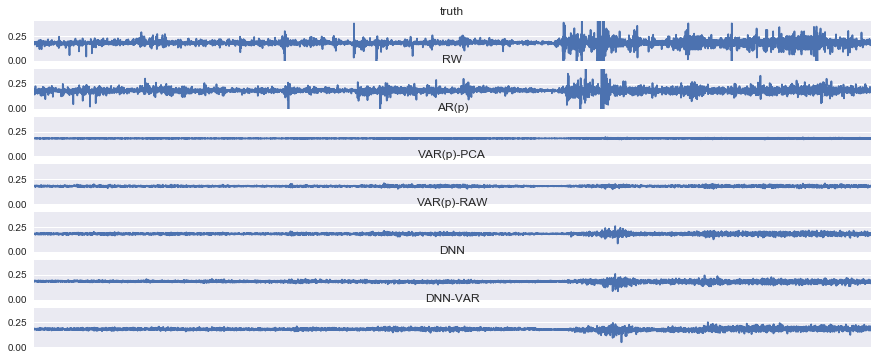

In [45]:
keys = models

plt.figure(figsize=(15,1*len(keys)))
count = 1
plt.subplot(len(keys)+1,1,1)
truth = results["RW"][30][2]
plt.plot(truth)
plt.xlim(0, len(truth))
plt.ylim(0, 0.4)
plt.title("truth")
plt.xticks([],[])

for k in keys:
    plt.subplot(len(keys)+1,1,count+1)
    plt.plot(results[k][30][1])
    count += 1
    plt.xlim(0, len(truth))
    plt.ylim(0, 0.4)
    plt.xticks([],[])
    plt.title(k)
plt.savefig("prediction2.png")

plt.show()

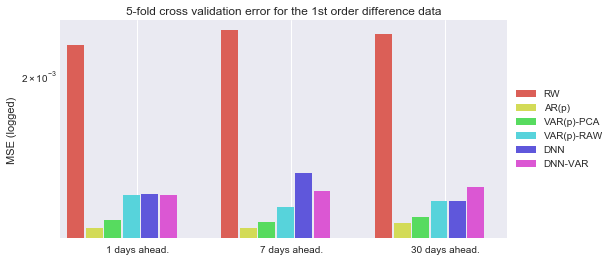

In [44]:
plt.figure(figsize=(8,4))
count = 0
colors = sns.color_palette("hls", len(models))

for m in models:
    d = [results[m][i][0] for i in futures]
    r = [0.12*count+i for i in range(3)]
    plt.bar(r, d, width=0.11, color=colors[count], label=m)
    count += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale("log")

plt.xlim(-0.1,2.8)
plt.xticks([],[])
plt.xticks([1.0*(i+1)-0.6 for i in range(3)],[str(f)+" days ahead." for f in futures])

plt.ylabel("MSE (logged)")
plt.title("5-fold cross validation error for the 1st order difference data")
plt.savefig("yieldcurve2.png")
plt.show()